# Basic Naive1 Model - 1

---

#### Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Baseline, evaluation and cross-validation forecast methods
from forecast_tools.baseline import Naive1, SNaive

from forecast_tools.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    winkler_score,
)

import ts_utils

#### Loading Data

In [2]:
# Load in the dataset
appoints = pd.read_csv("paediatrics_train.csv",
                       index_col="date",
                       parse_dates=True)

appoints.index.freq = "D"

In [3]:
# Data overview and show the first 5 rows
appoints.info()
appoints.describe()
appoints.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1056 entries, 2014-04-01 to 2017-02-19
Freq: D
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   paed_ed_attends  1056 non-null   int64
dtypes: int64(1)
memory usage: 16.5 KB


,paed_ed_attends
date,
2014-04-01,47
2014-04-02,46
2014-04-03,47
2014-04-04,48
2014-04-05,52


In [4]:
# Train-test split: Training (all but the last 28 days)
# and testing (the last 28 days)
train = appoints.iloc[:-28]
test = appoints.iloc[-28:]

In [5]:
# Baseline Models (Naive 1 & Seasonal Naive)
nv1 = Naive1()
sn1 = SNaive(28)

In [6]:
nv1.fit(train["paed_ed_attends"])
sn1.fit(train["paed_ed_attends"])

In [7]:
train.tail()

,paed_ed_attends
date,
2017-01-18,56
2017-01-19,44
2017-01-20,55
2017-01-21,44
2017-01-22,50


In [8]:
# Predict on validation data (set horizon to 28 days for validation)
preds_nv1, interval_nv1 = nv1.predict(
    horizon=28, return_predict_int=True, alpha=[0.2, 0.1]
)

preds_snv, interval_sn1 = sn1.predict(
    horizon=28, return_predict_int=True, alpha=[0.2, 0.1]
)

In [9]:
# Converting predictions into a DataFrame
preds_nv1 = ts_utils.preds_as_series(data=train, preds=preds_nv1)
preds_snv = ts_utils.preds_as_series(data=train, preds=preds_snv)

In [10]:
# Calculate MAE for both single models
mae_nv1_test = mean_absolute_error(y_true=test, y_pred=preds_nv1)
mape_nv1_test = mean_absolute_percentage_error(y_true=test, y_pred=preds_nv1)

mae_snv_test = mean_absolute_error(y_true=test, y_pred=preds_snv)
mape_snv_test = mean_absolute_percentage_error(y_true=test, y_pred=preds_snv)

print(
    f"Naive1 - Single Test Run MAE: {mae_nv1_test:.2f},"
    f" MAPE: {mape_nv1_test:.2f}%"
)
print(
    f"SNaive - Single Test Run MAE: {mae_snv_test:.2f},"
    f" MAPE: {mape_snv_test:.2f}%"
)

Naive1 - Single Test Run MAE: 7.39, MAPE: 14.70%
SNaive - Single Test Run MAE: 9.14, MAPE: 17.62%


# Cross Validation Section

In [11]:
# Rolling  Window & Cross Validation
def rolling_cross_validation(model, train, min_train_size, horizon, metric):
    scores = []
    for i in range(len(train) - min_train_size - horizon + 1):
        split_train = train[: min_train_size + i]
        split_test = train[min_train_size + i: min_train_size + i + horizon]
        model.fit(split_train)
        pred = model.predict(horizon)
        score = metric(split_test, pred)
        scores.append(score)

    return np.array(scores)

In [12]:
# Double checking the fold size
len(train) - len(train) // 3 - 28 + 28

686

In [13]:
min_train_size = len(train) // 3
horizon = 28

scores_nv1 = rolling_cross_validation(
    model=nv1,
    train=train,
    min_train_size=min_train_size,
    horizon=horizon,
    metric=mean_absolute_error,
)

In [14]:
# The average of all of the folds MAE score
print(f"Overall Cross Validation Mean for Naive1: {scores_nv1.mean():.2f}")

Overall Cross Validation Mean for Naive1: 9.66


In [15]:
scores_sn1 = rolling_cross_validation(
    model=sn1,
    train=train,
    min_train_size=min_train_size,
    horizon=horizon,
    metric=mean_absolute_error,
)

In [16]:
# The average of all of the folds MAE score
print(f"Overall Cross Validation Mean for Seasonal Naive:"
      f" {scores_sn1.mean():.2f}")

Overall Cross Validation Mean for Seasonal Naive: 10.48


In [17]:
# The Winkler Score for the Naive1 Model 80%
nv1_wink_score_eighty = winkler_score(
    intervals=interval_nv1[0], observations=test, alpha=0.2
)

# The Winkler Score for the Naive1 Model 90%
nv1_wink_score_ninety = winkler_score(
    intervals=interval_nv1[1], observations=test, alpha=0.1
)

# The Winkler Score for the Seasonal Naive Model 80%
sn1_wink_score_eighty = winkler_score(
    intervals=interval_sn1[0], observations=test, alpha=0.2
)

# The Winkler Score for the Seasonal Naive Model 90%
sn1_wink_score_ninety = winkler_score(
    intervals=interval_sn1[1], observations=test, alpha=0.1
)

print(
    f"Naive1 Winkler Score for the 80% prediction interval:"
    f" {nv1_wink_score_eighty:.2f}"
)

print(
    f"Naive1 Winkler Score for the 90% prediction interval:"
    f" {nv1_wink_score_ninety:.2f}\n"
)

print(
    f"Seasonal Naive Winkler Score for the 80% prediction interval:"
    f" {sn1_wink_score_eighty:.2f}"
)

print(
    f"Seasonal Naive Winkler Score for the 90% prediction interval:"
    f" {sn1_wink_score_ninety:.2f}"
)

Naive1 Winkler Score for the 80% prediction interval: 96.15
Naive1 Winkler Score for the 90% prediction interval: 123.41

Seasonal Naive Winkler Score for the 80% prediction interval: 42.16
Seasonal Naive Winkler Score for the 90% prediction interval: 51.99


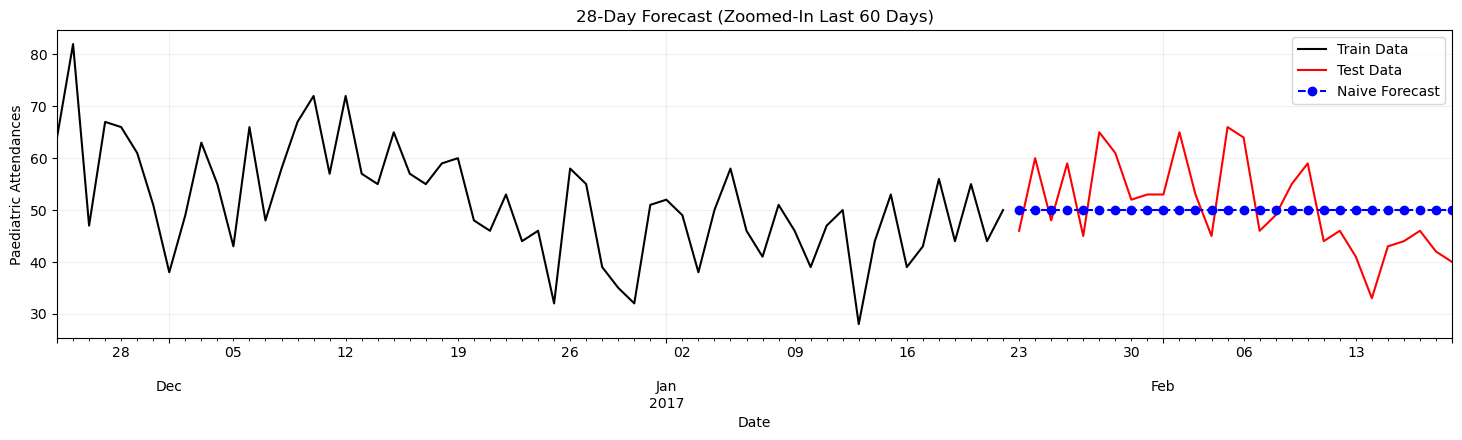

In [18]:
# Zoomed-in Plot (Last 60 Days)
fig, ax = plt.subplots(figsize=(18, 4))
train.iloc[-60:].plot(ax=ax,
                      label="Training Data (Last 60 Days)",
                      color="black")

test.plot(ax=ax,
          label="Test Data",
          color="red")

preds_nv1.plot(ax=ax,
               marker="o",
               linestyle="dashed",
               color="blue",
               label="Forecast")

ax.set_xlabel("Date")
ax.set_ylabel("Paediatric Attendances")
ax.set_title("28-Day Forecast (Zoomed-In Last 60 Days)")
ax.legend(["Train Data", "Test Data", "Naive Forecast"])
plt.grid(True, alpha=0.2)
plt.show()

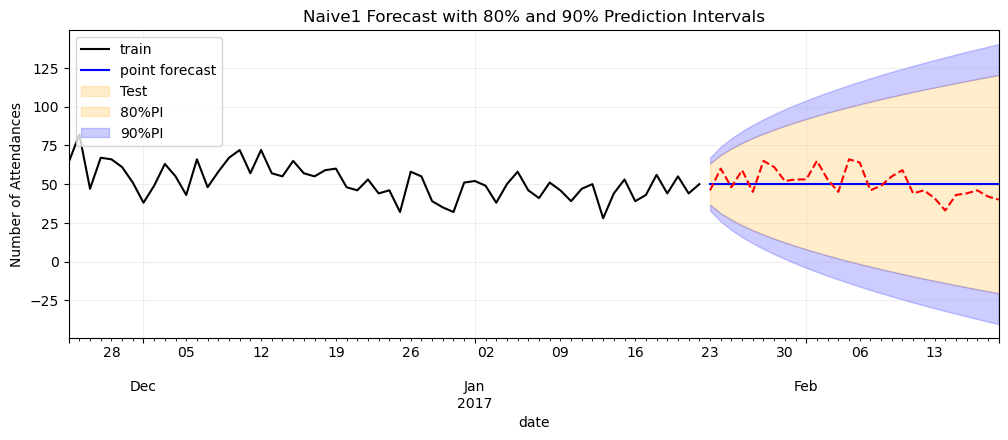

In [19]:
ts_utils.plot_prediction_intervals(
    train=train[-60:],
    preds=preds_nv1,
    intervals=interval_nv1,
    test=test,
    title="Naive1 Forecast with 80% and 90% Prediction Intervals"
)

---

#### Save Predictions to a CSV

In [27]:
# Folder where the CSV will be saved
output_folder = "model_predictions"  # Ensure this folder exists

# Convert Naive1 predictions to a DataFrame
forecast_df_nv1 = preds_nv1.to_frame(name="Naive1_Forecast").reset_index()

# Add 80% and 90% Prediction Intervals
forecast_df_nv1["Lower_80_PI"] = interval_nv1[0][:, 0] # Lower bound of 80% PI
forecast_df_nv1["Upper_80_PI"] = interval_nv1[0][:, 1] # Upper bound of 80% PI
forecast_df_nv1["Lower_90_PI"] = interval_nv1[1][:, 0] # Lower bound of 90% PI
forecast_df_nv1["Upper_90_PI"] = interval_nv1[1][:, 1] # Upper bound of 90% PI

# Renaming columns for clarity
forecast_df_nv1.columns = ["Date",
                           "Naive1_Forecast",
                           "Lower_80_PI",
                           "Upper_80_PI",
                           "Lower_90_PI",
                           "Upper_90_PI"]

# Save to CSV inside "model_predictions" folder
forecast_path_nv1 = f"{output_folder}/naive1_forecast.csv"
forecast_df_nv1.to_csv(forecast_path_nv1, index=False)

print(f"Naive1 forecast saved in {forecast_path_nv1}")
print(forecast_df_nv1.head())

Naive1 forecast saved in model_predictions/naive1_forecast.csv
        Date  Naive1_Forecast  Lower_80_PI  Upper_80_PI  Lower_90_PI  \
0 2017-01-23             50.0    36.701132    63.298868    32.931087   
1 2017-01-24             50.0    31.192560    68.807440    25.860912   
2 2017-01-25             50.0    26.965685    73.034315    20.435776   
3 2017-01-26             50.0    23.402264    76.597736    15.862175   
4 2017-01-27             50.0    20.262827    79.737173    11.832751   

   Upper_90_PI  
0    67.068913  
1    74.139088  
2    79.564224  
3    84.137825  
4    88.167249  


*Page 3*